In [1]:
import os

from hiive.mdptoolbox import example, mdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### functions

In [2]:
def simulate_forest_policy(P, R, policy, n=1000, episode_len=100, seed=42):
    rewards = []
    start = 0
    np.random.seed(seed)
    for i in range(n):
        reward = 0
        pos = start
        for e in range(episode_len):
            action = policy[pos]
            reward += R[pos][action]
            p = np.random.uniform(0, 1)
            pos = (P[action][pos].cumsum() > p).argmax()
        rewards.append(reward)
    return rewards

In [ ]:
def save_results(results, keys=None, folder=None):
    if folder is None:
        folder = './results'
    if not os.path.exists(folder):
        os.mkdir(folder)
    if keys is None:
        keys = []
    for k, v in results.items():
        if isinstance(v, dict):
            save_results(v, keys + [str(k)], folder)
        else:
            path = os.path.join(folder, '_'.join(keys + [str(k)]) + '.csv')
            if isinstance(v, pd.DataFrame):
                v.to_csv(path, index=False)
            elif isinstance(v, (list, tuple, np.array)):
                np.savetxt(path, v)
            else:
                print('ERROR', path)
    return

#### setup problems

In [3]:
results = {}
policies = {}
simulations = {}

#### forest

In [4]:
prob = 'forest'
sizes = {'small': 8, 'large': 16}
results.setdefault(prob, {})
policies.setdefault(prob, {})
simulations.setdefault(prob, {})
P = {}
R = {}

In [5]:
for size in sizes:
    P[size], R[size] = example.forest(sizes[size])

In [257]:
mdp._util.getSpan = lambda x: abs(x).max()

In [258]:
# VI
method = 'value_iteration'
size = 'small'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e7)
gammas = [.5, .9, .99, .999, .9999, .99999]
epsilons = [.5, .1, .05, .01, .005, .001]
df = []
for g in gammas:
    policies[prob][size][method].setdefault(g, {})
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        VI = mdp.ValueIteration(P[size], R[size], gamma=g, epsilon=e, max_iter=max_iter)
        VI.max_iter = max_iter
        scores = VI.run()
        for r in scores:
            df.append((prob, size, method, g, e, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
        policies[prob][size][method][g][e] = [p.copy() for _, p in VI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [259]:
df.groupby(['gamma', 'epsilon'])['mean_value'].max().to_frame().unstack()

mean_value                                               \
epsilon          0.001          0.005          0.010          0.050   
gamma                                                                 
0.50000       2.255785       2.254403       2.252647       2.240424   
0.90000      15.617483      15.613731      15.608578      15.570479   
0.99000     187.328571     187.324597     187.319624     187.279927   
0.99900    1909.144939    1909.140939    1909.135948    1909.095967   
0.99990   19127.828040   19127.824040   19127.819041   19127.779042   
0.99999  191314.711513  191314.707511  191314.702512  191314.662512   

                                       
epsilon          0.100          0.500  
gamma                                  
0.50000       2.220348       2.096578  
0.90000      15.528178      15.131265  
0.99000     187.230256     186.833702  
0.99900    1909.045975    1908.646435  
0.99990   19127.729046   19127.329051  
0.99999  191314.612515  191314.212519

In [260]:
df.groupby(['gamma', 'epsilon'])['iter'].max().to_frame().unstack()

iter                                             
epsilon    0.001    0.005    0.010    0.050    0.100    0.500
gamma                                                        
0.50000       12       10        9        7        6        4
0.90000       93       78       71       56       50       34
0.99000     1210     1050      981      821      752      592
0.99900    14457    12848    12156    10547     9854     8246
0.99990   167661   151567   144636   128542   121611   105517
0.99999  1907184  1746006  1676690  1515738  1446425  1285479

In [267]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
ep_len = 100
i = 0
for g in gammas:
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        r = simulate_forest_policy(
            P[size], R[size], policies[prob][size][method][g][e][-1], n, ep_len, 42*i
        )
        df.append((prob, size, method, g, e, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [282]:
df.groupby(['gamma', 'epsilon'])['avg_reward'].mean().unstack()

epsilon,0.001,0.005,0.010,0.050,0.100,0.500
gamma,,,,,,
0.50000,47.097,47.097,47.097,47.097,47.097,47.097
0.90000,173.908,173.908,173.908,173.908,173.908,173.908
0.99000,173.908,173.908,173.908,173.908,173.908,173.908
0.99900,173.908,173.908,173.908,173.908,173.908,173.908
0.99990,173.908,173.908,173.908,173.908,173.908,173.908
0.99999,173.908,173.908,173.908,173.908,173.908,173.908


In [261]:
# VI
method = 'value_iteration'
size = 'large'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e7)
gammas = [.5, .9, .99, .999, .9999, .99999]
epsilons = [.5, .1, .05, .01, .005, .001]
df = []
for g in gammas:
    policies[prob][size][method].setdefault(g, {})
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        VI = mdp.ValueIteration(P[size], R[size], gamma=g, epsilon=e, max_iter=max_iter)
        VI.max_iter = max_iter
        scores = VI.run()
        for r in scores:
            df.append((prob, size, method, g, e, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
        policies[prob][size][method][g][e] = [p.copy() for _, p in VI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [262]:
df.groupby(['gamma', 'epsilon'])['mean_value'].max().to_frame().unstack()

mean_value                                                          \
epsilon         0.001         0.005         0.010         0.050         0.100   
gamma                                                                           
0.50000      1.782937      1.781850      1.780708      1.772362      1.756438   
0.90000      9.258037      9.254435      9.249466      9.211942      9.168670   
0.99000     82.054126     82.050134     82.045140     82.005265     81.955373   
0.99900    823.333543    823.329545    823.324545    823.284590    823.234619   
0.99990   8235.421784   8235.417784   8235.412784   8235.372788   8235.322794   
0.99999  82356.230091  82356.226092  82356.221091  82356.181092  82356.131097   

                       
epsilon         0.500  
gamma                  
0.50000      1.666414  
0.90000      8.904507  
0.99000     81.557051  
0.99900    822.834741  
0.99990   8234.922811  
0.99999  82355.731099

In [263]:
df.groupby(['gamma', 'epsilon'])['iter'].max().to_frame().unstack()

iter                                             
epsilon    0.001    0.005    0.010    0.050    0.100    0.500
gamma                                                        
0.50000       12       10        9        7        6        4
0.90000       81       66       59       44       38       26
0.99000     1120      960      891      731      662      502
0.99900    13610    12001    11308     9700     9007     7398
0.99990   159227   143133   136202   120109   113178    97084
0.99999  1822645  1661723  1592388  1431444  1362133  1201186

In [269]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
ep_len = 500
i = 0
for g in gammas:
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        r = simulate_forest_policy(
            P[size], R[size], policies[prob][size][method][g][e][-1], n, ep_len, 42*i
        )
        df.append((prob, size, method, g, e, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [283]:
df.groupby(['gamma', 'epsilon'])['avg_reward'].mean().unstack()

epsilon,0.001,0.005,0.010,0.050,0.100,0.500
gamma,,,,,,
0.50000,236.510,236.510,236.510,236.510,236.510,236.510
0.90000,236.510,236.510,236.510,236.510,236.510,236.510
0.99000,390.012,390.012,390.012,390.012,390.012,390.012
0.99900,390.012,390.012,390.012,390.012,390.012,390.012
0.99990,390.012,390.012,390.012,390.012,390.012,390.012
0.99999,390.012,390.012,390.012,390.012,390.012,390.012


In [320]:
for i in range(20, 30):
    print(i)
    for j in [.9, .99, .999, .9999, .99999]:
        PI = mdp.PolicyIteration(*example.forest(i), gamma=j, max_iter=100)
        PI.run()
        print(j, sum(PI.policy))

20
0.9 9
0.99 1
0.999 0
0.9999 0
0.99999 0
21
0.9 10
0.99 2
0.999 0
0.9999 0
0.99999 0
22
0.9 11
0.99 3
0.999 1
0.9999 1
0.99999 1
23
0.9 12
0.99 4
0.999 2
0.9999 2
0.99999 2
24
0.9 13
0.99 5
0.999 3
0.9999 3
0.99999 3
25
0.9 14
0.99 6
0.999 4
0.9999 4
0.99999 4
26
0.9 15
0.99 7
0.999 5
0.9999 5
0.99999 5
27
0.9 16
0.99 8
0.999 6
0.9999 6
0.99999 6
28
0.9 17
0.99 9
0.999 7
0.9999 7
0.99999 7
29
0.9 18
0.99 10
0.999 8
0.9999 8
0.99999 8


In [12]:
# PI
method = 'policy_iteration'
size = 'small'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e2)
gammas = [.5, .9, .99, .999, .9999, .99999]
df = []
for g in gammas:
    print(f'Gamma: {g}')
    PI = mdp.PolicyIteration(P[size], R[size], gamma=g, max_iter=max_iter)
    scores = PI.run()
    for r in scores:
        df.append((prob, size, method, g, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
    policies[prob][size][method][g] = [p.copy() for _, p in PI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [13]:
df.groupby('gamma')['mean_value'].max().to_frame()

,mean_value
gamma,
0.50000,2.256191
0.90000,15.618456
0.99000,187.329566
0.99900,1909.145939
0.99990,19127.829040
0.99999,191314.712511


In [14]:
df.groupby('gamma')['iter'].max().to_frame()

,iter
gamma,
0.50000,3
0.90000,7
0.99000,7
0.99900,7
0.99990,7
0.99999,7


In [277]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
ep_len = 100
i = 0
for g in gammas:
    print(f'Gamma: {g}')
    r = simulate_forest_policy(
        P[size], R[size], policies[prob][size][method][g][-1], n, ep_len, 42*i
    )
    df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [287]:
df.groupby('gamma')['avg_reward'].mean().to_frame()

,avg_reward
gamma,
0.50000,47.097
0.90000,173.908
0.99000,173.908
0.99900,173.908
0.99990,173.908
0.99999,173.908


In [15]:
# PI
method = 'policy_iteration'
size = 'large'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e2)
gammas = [.5, .9, .99, .999, .9999, .99999]
df = []
for g in gammas:
    print(f'Gamma: {g}')
    PI = mdp.PolicyIteration(P[size], R[size], gamma=g, max_iter=max_iter)
    scores = PI.run()
    for r in scores:
        df.append((prob, size, method, g, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
    policies[prob][size][method][g] = [p.copy() for _, p in PI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [16]:
df.groupby('gamma')['mean_value'].max().to_frame()

,mean_value
gamma,
0.50000,1.783268
0.90000,9.258969
0.99000,82.055125
0.99900,823.334542
0.99990,8235.422784
0.99999,82356.231091


In [17]:
df.groupby('gamma')['iter'].max().to_frame()

,iter
gamma,
0.50000,3
0.90000,10
0.99000,15
0.99900,15
0.99990,15
0.99999,15


In [279]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
ep_len = 500
i = 0
for g in gammas:
    print(f'Gamma: {g}')
    r = simulate_forest_policy(
        P[size], R[size], policies[prob][size][method][g][-1], n, ep_len, 42*i
    )
    df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [288]:
df.groupby('gamma')['avg_reward'].mean().to_frame()

,avg_reward
gamma,
0.50000,236.510
0.90000,236.510
0.99000,390.012
0.99900,390.012
0.99990,390.012
0.99999,390.012


In [32]:
# Q - gamma tuning
method = 'q_learning'
size = 'small'
param = 'gamma'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
n_iter = int(1e7)
gammas = [.5, .9, .99, .999, .9999, .99999]
runs = range(5)
a_0 = 1
a = .9999
e_0 = 1
e = .9999
iter_callback = None
df = []
for g in gammas:
    policies[prob][size][method][param].setdefault(g, {})
    for i in runs:
        print(f'Gamma: {g} \tRun: {i}')
        np.random.seed(42*i)
        QL = mdp.QLearning(
            P[size],
            R[size],
            gamma=g,
            alpha=a_0,
            alpha_decay=a,
            epsilon=e_0,
            epsilon_decay=e,
            iter_callback=iter_callback,
            n_iter=n_iter
        )
        scores = QL.run()
        for r in scores:
            df.append((
                prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, r['Iteration'], r['Time'], r['Mean V'],
                r['Error']
            ))
        policies[prob][size][method][param][g][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'iter', 'time',
    'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Gamma: 0.5 	Run: 0
Gamma: 0.5 	Run: 1
Gamma: 0.5 	Run: 2
Gamma: 0.5 	Run: 3
Gamma: 0.5 	Run: 4
Gamma: 0.9 	Run: 0
Gamma: 0.9 	Run: 1
Gamma: 0.9 	Run: 2
Gamma: 0.9 	Run: 3
Gamma: 0.9 	Run: 4
Gamma: 0.99 	Run: 0
Gamma: 0.99 	Run: 1
Gamma: 0.99 	Run: 2
Gamma: 0.99 	Run: 3
Gamma: 0.99 	Run: 4
Gamma: 0.999 	Run: 0
Gamma: 0.999 	Run: 1
Gamma: 0.999 	Run: 2
Gamma: 0.999 	Run: 3
Gamma: 0.999 	Run: 4
Gamma: 0.9999 	Run: 0
Gamma: 0.9999 	Run: 1
Gamma: 0.9999 	Run: 2
Gamma: 0.9999 	Run: 3
Gamma: 0.9999 	Run: 4
Gamma: 0.99999 	Run: 0
Gamma: 0.99999 	Run: 1
Gamma: 0.99999 	Run: 2
Gamma: 0.99999 	Run: 3
Gamma: 0.99999 	Run: 4


In [33]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
ep_len = 100
for g in gammas:
    print(f'Gamma: {g}')
    for i in runs:
        r = simulate_forest_policy(P[size], R[size], policies[prob][size][method][param][g][i][-1], n, ep_len, 42*i)
        df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [34]:
policies[prob][size][method][param][.9][0][-1]

array([0, 0, 0, 0, 0, 0, 0, 0])

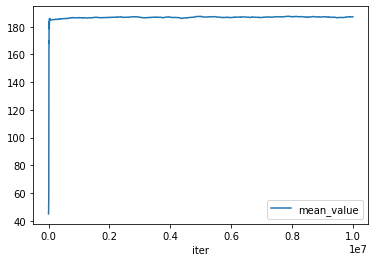

In [35]:
results[prob][size][method][param].query(
    'run==3 and gamma==.99'
).plot('iter', 'mean_value')

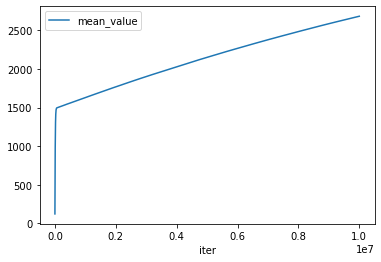

In [36]:
results[prob][size][method][param].query(
    'run==3 and gamma==.9999'
).plot('iter', 'mean_value')

In [37]:
df.groupby('gamma')['avg_reward'].describe()

,count,mean,std,min,25%,50%,75%,max
gamma,,,,,,,,
0.50000,5.0,47.1280,0.019962,47.097,47.122,47.135,47.136,47.15
0.90000,5.0,177.1472,2.058682,173.908,176.720,177.276,178.872,178.96
0.99000,5.0,177.1472,2.058682,173.908,176.720,177.276,178.872,178.96
0.99900,5.0,47.1280,0.019962,47.097,47.122,47.135,47.136,47.15
0.99990,5.0,47.1280,0.019962,47.097,47.122,47.135,47.136,47.15
0.99999,5.0,47.1280,0.019962,47.097,47.122,47.135,47.136,47.15


In [38]:
# Q - alpha tuning
method = 'q_learning'
size = 'small'
param = 'alpha'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .9
runs = range(5)
a_0 = 1
alpha_mins = [.1, .01, .001, .0001, .00001]
alpha_decays = [.999, .9999, .99999, .999999]
e_0 = 1
e = .9999
iter_callback = None
df = []
for a in alpha_decays:
    policies[prob][size][method][param].setdefault(a, {})
    for a_min in alpha_mins:
        policies[prob][size][method][param][a].setdefault(a_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a)))
        n_iter = int(1e7)
        for i in runs:
            print(f'Alpha Decay: {a} \tAlpha Min: {a_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][a][a_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'alpha_min', 'iter',
    'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 1
Alpha Decay: 0.999 	

In [40]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
ep_len = 100
for a in alpha_decays:
    for a_min in alpha_mins:
        print(f'Alpha Decay: {a} \tAlpha Min: {a_min}')
        for i in runs:
            r = simulate_forest_policy(
                P[size], R[size], policies[prob][size][method][param][a][a_min][i][-1], n, ep_len, 42*i
            )
            df.append((prob, size, method, a, a_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'alpha_decay', 'alpha_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.1
Alpha Decay: 0.999 	Alpha Min: 0.01
Alpha Decay: 0.999 	Alpha Min: 0.001
Alpha Decay: 0.999 	Alpha Min: 0.0001
Alpha Decay: 0.999 	Alpha Min: 1e-05
Alpha Decay: 0.9999 	Alpha Min: 0.1
Alpha Decay: 0.9999 	Alpha Min: 0.01
Alpha Decay: 0.9999 	Alpha Min: 0.001
Alpha Decay: 0.9999 	Alpha Min: 0.0001
Alpha Decay: 0.9999 	Alpha Min: 1e-05
Alpha Decay: 0.99999 	Alpha Min: 0.1
Alpha Decay: 0.99999 	Alpha Min: 0.01
Alpha Decay: 0.99999 	Alpha Min: 0.001
Alpha Decay: 0.99999 	Alpha Min: 0.0001
Alpha Decay: 0.99999 	Alpha Min: 1e-05
Alpha Decay: 0.999999 	Alpha Min: 0.1
Alpha Decay: 0.999999 	Alpha Min: 0.01
Alpha Decay: 0.999999 	Alpha Min: 0.001
Alpha Decay: 0.999999 	Alpha Min: 0.0001
Alpha Decay: 0.999999 	Alpha Min: 1e-05


In [41]:
df.groupby(['alpha_decay', 'alpha_min'])['avg_reward'].describe()

count      mean       std      min      25%      50%  \
alpha_decay alpha_min                                                         
0.999000    0.00001      5.0   47.1280  0.019962   47.097   47.122   47.135   
            0.00010      5.0   47.1280  0.019962   47.097   47.122   47.135   
            0.00100      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.01000      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.10000      5.0  177.1472  2.058682  173.908  176.720  177.276   
0.999900    0.00001      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.00010      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.00100      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.01000      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.10000      5.0  177.1472  2.058682  173.908  176.720  177.276   
0.999990    0.00001      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.00010      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.00100      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.01000      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.10000      5.0  177.1472  2.058682  173.908  176.720  177.276   
0.999999    0.00001      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.00010      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.00100      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.01000      5.0  177.1472  2.058682  173.908  176.720  177.276   
            0.10000      5.0  177.1472  2.058682  173.908  176.720  177.276   

                           75%     max  
alpha_decay alpha_min                   
0.999000    0.00001     47.136   47.15  
            0.00010     47.136   47.15  
            0.00100    178.872  178.96  
            0.01000    178.872  178.96  
            0.10000    178.872  178.96  
0.999900    0.00001    178.872  178.96  
            0.00010    178.872  178.96  
            0.00100    178.872  178.96  
            0.01000    178.872  178.96  
            0.10000    178.872  178.96  
0.999990    0.00001    178.872  178.96  
            0.00010    178.872  178.96  
            0.00100    178.872  178.96  
            0.01000    178.872  178.96  
            0.10000    178.872  178.96  
0.999999    0.00001    178.872  178.96  
            0.00010    178.872  178.96  
            0.00100    178.872  178.96  
            0.01000    178.872  178.96  
            0.10000    178.872  178.96

0.999 1e-05


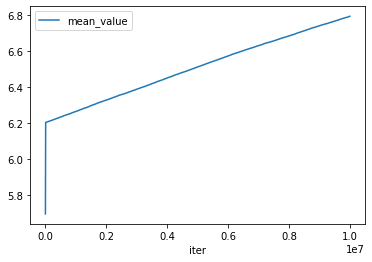

0.999 0.0001


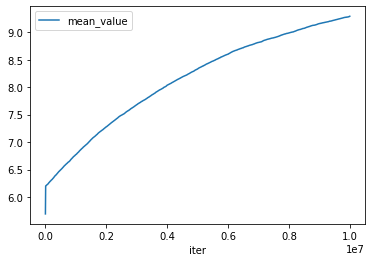

0.999 0.001


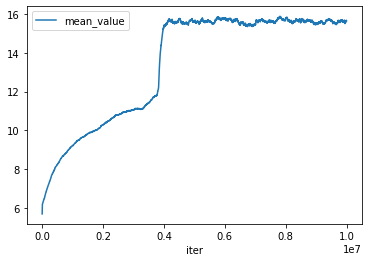

0.999 0.01


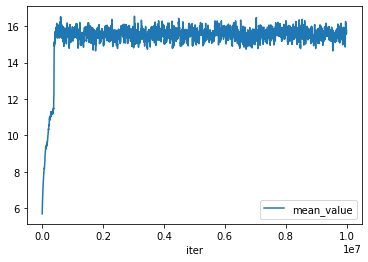

0.999 0.1


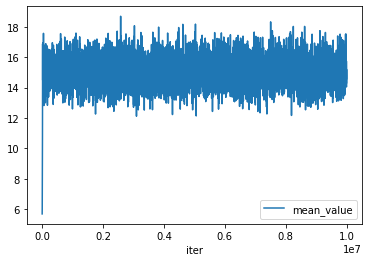

0.9999 1e-05


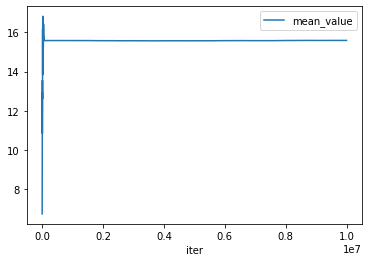

0.9999 0.0001


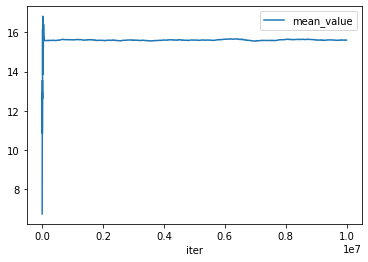

0.9999 0.001


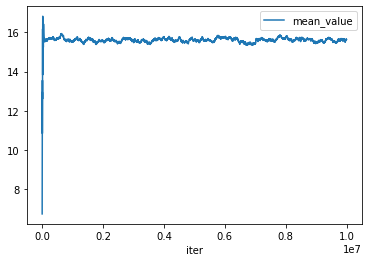

0.9999 0.01


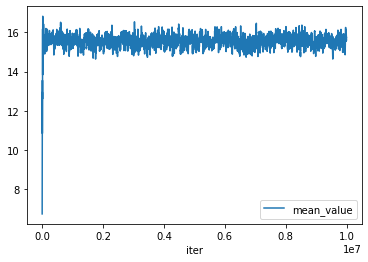

0.9999 0.1


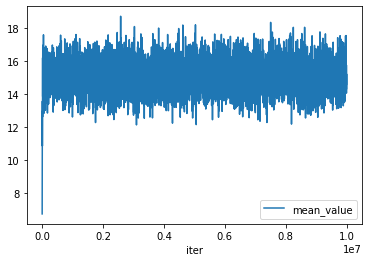

0.99999 1e-05


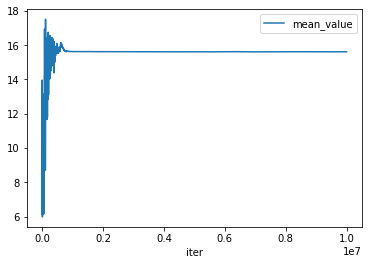

0.99999 0.0001


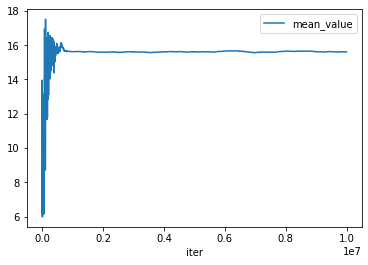

0.99999 0.001


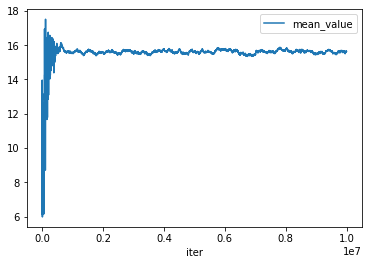

0.99999 0.01


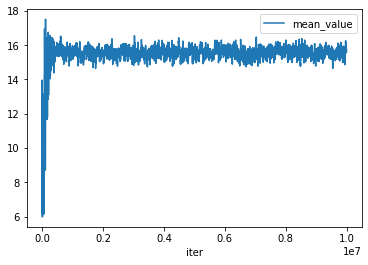

0.99999 0.1


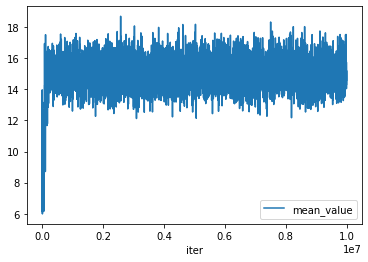

0.999999 1e-05


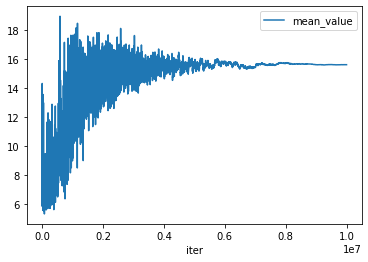

0.999999 0.0001


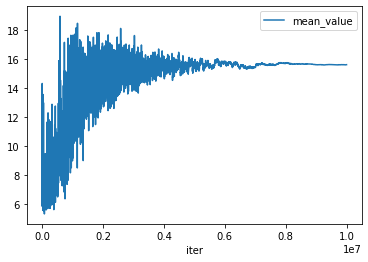

0.999999 0.001


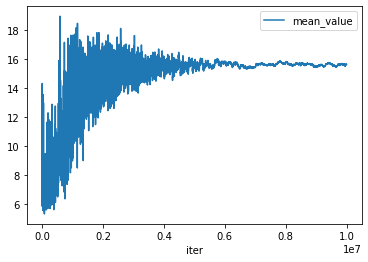

0.999999 0.01


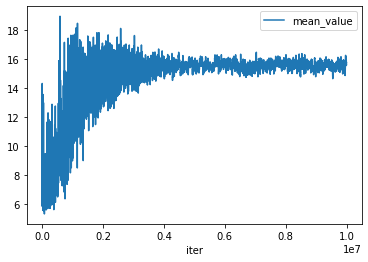

0.999999 0.1


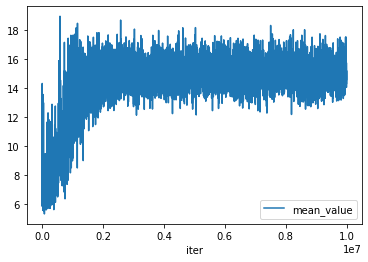

In [423]:
for a in sorted(df['alpha_decay'].unique()):
    for a_min in sorted(df['alpha_min'].unique()):
        print(a, a_min)
        results[prob][size][method][param].query(
            'alpha_decay==@a and alpha_min==@a_min and run==4'
        ).plot('iter', 'mean_value')
        plt.show()

In [69]:
# Q - epsilon tuning
method = 'q_learning'
size = 'small'
param = 'epsilon'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .9
runs = range(5)
a_0 = 1
a_min = 1e-5
a = .9999
e_0 = 1
epsilon_decays = [.99, .999, .9999, .99999, .999999]
epsilon_mins = [.5, .3, .1, .05, .01]
iter_callback = None
df = []
for e in epsilon_decays:
    policies[prob][size][method][param].setdefault(e, {})
    for e_min in epsilon_mins:
        policies[prob][size][method][param][e].setdefault(e_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a), 2*np.log(e_min)/np.log(e)))
        n_iter = int(1e5)
        for i in runs:
            print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                epsilon_min=e_min,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, e_min, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][e][e_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'epsilon_min', 'alpha', 'alpha_decay',
    'alpha_min', 'iter', 'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.01 	Run: 0
Epsilon Decay: 0.99 	Epsilon

In [70]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
ep_len = 100
for e in epsilon_decays:
    for e_min in epsilon_mins:
        print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min}')
        for i in runs:
            r = simulate_forest_policy(
                P[size], R[size], policies[prob][size][method][param][e][e_min][i][-1], n, ep_len, 42*i
            )
            df.append((prob, size, method, e, e_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'epsilon_decay', 'epsilon_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5
Epsilon Decay: 0.99 	Epsilon Min: 0.3
Epsilon Decay: 0.99 	Epsilon Min: 0.1
Epsilon Decay: 0.99 	Epsilon Min: 0.05
Epsilon Decay: 0.99 	Epsilon Min: 0.01
Epsilon Decay: 0.999 	Epsilon Min: 0.5
Epsilon Decay: 0.999 	Epsilon Min: 0.3
Epsilon Decay: 0.999 	Epsilon Min: 0.1
Epsilon Decay: 0.999 	Epsilon Min: 0.05
Epsilon Decay: 0.999 	Epsilon Min: 0.01
Epsilon Decay: 0.9999 	Epsilon Min: 0.5
Epsilon Decay: 0.9999 	Epsilon Min: 0.3
Epsilon Decay: 0.9999 	Epsilon Min: 0.1
Epsilon Decay: 0.9999 	Epsilon Min: 0.05
Epsilon Decay: 0.9999 	Epsilon Min: 0.01
Epsilon Decay: 0.99999 	Epsilon Min: 0.5
Epsilon Decay: 0.99999 	Epsilon Min: 0.3
Epsilon Decay: 0.99999 	Epsilon Min: 0.1
Epsilon Decay: 0.99999 	Epsilon Min: 0.05
Epsilon Decay: 0.99999 	Epsilon Min: 0.01
Epsilon Decay: 0.999999 	Epsilon Min: 0.5
Epsilon Decay: 0.999999 	Epsilon Min: 0.3
Epsilon Decay: 0.999999 	Epsilon Min: 0.1
Epsilon Decay: 0.999999 	Epsilon Min: 0.05
Epsilon Decay: 0.999999 	Epsilon 

In [71]:
df.groupby(['epsilon_decay', 'epsilon_min'])['avg_reward'].describe()

count      mean        std      min      25%  \
epsilon_decay epsilon_min                                                 
0.990000      0.01           5.0   47.1280   0.019962   47.097   47.122   
              0.05           5.0   73.0476  57.954637   47.097   47.135   
              0.10           5.0   99.0728  71.135923   47.097   47.135   
              0.30           5.0  151.7850  58.530566   47.097  176.720   
              0.50           5.0  177.1472   2.058682  173.908  176.720   
0.999000      0.01           5.0   47.1280   0.019962   47.097   47.122   
              0.05           5.0   47.1280   0.019962   47.097   47.122   
              0.10           5.0   47.1280   0.019962   47.097   47.122   
              0.30           5.0  151.7850  58.530566   47.097  176.720   
              0.50           5.0  177.1472   2.058682  173.908  176.720   
0.999900      0.01           5.0  177.1472   2.058682  173.908  176.720   
              0.05           5.0  177.1472   2.058682  173.908  176.720   
              0.10           5.0  177.1472   2.058682  173.908  176.720   
              0.30           5.0  177.1472   2.058682  173.908  176.720   
              0.50           5.0  177.1472   2.058682  173.908  176.720   
0.999990      0.01           5.0  177.1472   2.058682  173.908  176.720   
              0.05           5.0  177.1472   2.058682  173.908  176.720   
              0.10           5.0  177.1472   2.058682  173.908  176.720   
              0.30           5.0  177.1472   2.058682  173.908  176.720   
              0.50           5.0  177.1472   2.058682  173.908  176.720   
0.999999      0.01           5.0  177.1472   2.058682  173.908  176.720   
              0.05           5.0  177.1472   2.058682  173.908  176.720   
              0.10           5.0  177.1472   2.058682  173.908  176.720   
              0.30           5.0  177.1472   2.058682  173.908  176.720   
              0.50           5.0  177.1472   2.058682  173.908  176.720   

                               50%      75%      max  
epsilon_decay epsilon_min                             
0.990000      0.01          47.135   47.136   47.150  
              0.05          47.136   47.150  176.720  
              0.10          47.136  176.720  177.276  
              0.30         177.276  178.872  178.960  
              0.50         177.276  178.872  178.960  
0.999000      0.01          47.135   47.136   47.150  
              0.05          47.135   47.136   47.150  
              0.10          47.135   47.136   47.150  
              0.30         177.276  178.872  178.960  
              0.50         177.276  178.872  178.960  
0.999900      0.01         177.276  178.872  178.960  
              0.05         177.276  178.872  178.960  
              0.10         177.276  178.872  178.960  
              0.30         177.276  178.872  178.960  
              0.50         177.276  178.872  178.960  
0.999990      0.01         177.276  178.872  178.960  
              0.05         177.276  178.872  178.960  
              0.10         177.276  178.872  178.960  
              0.30         177.276  178.872  178.960  
              0.50         177.276  178.872  178.960  
0.999999      0.01         177.276  178.872  178.960  
              0.05         177.276  178.872  178.960  
              0.10         177.276  178.872  178.960  
              0.30         177.276  178.872  178.960  
              0.50         177.276  178.872  178.960

0.99 0.01


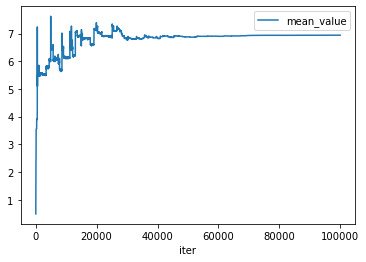

0.99 0.05


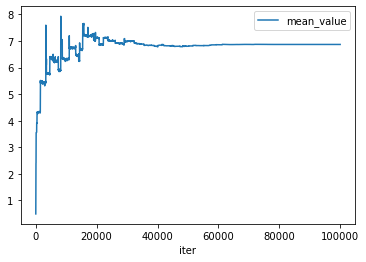

0.99 0.1


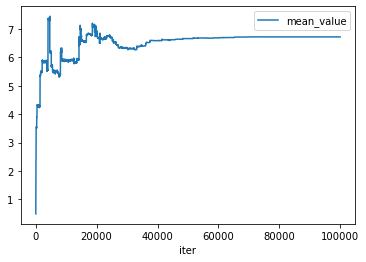

0.99 0.3


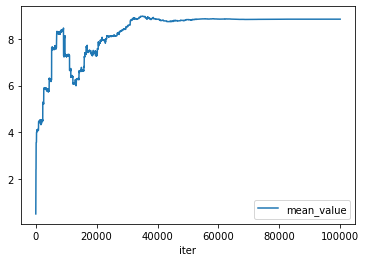

0.99 0.5


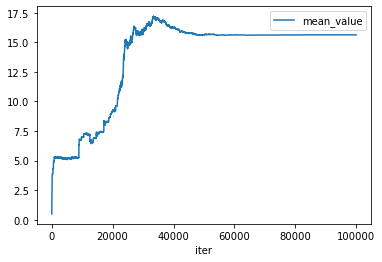

0.999 0.01


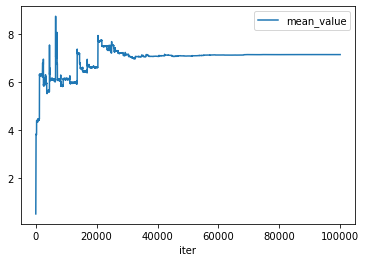

0.999 0.05


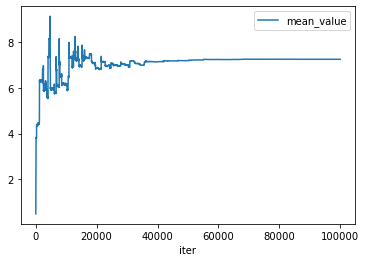

0.999 0.1


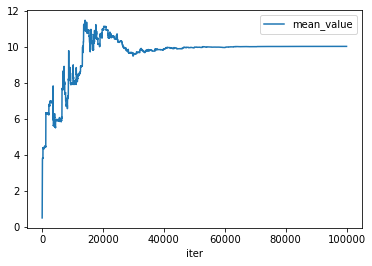

0.999 0.3


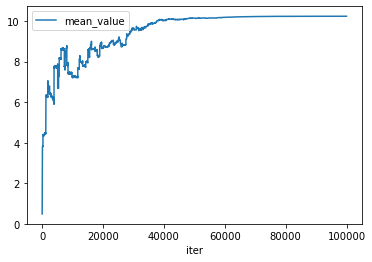

0.999 0.5


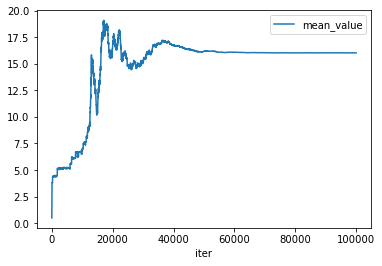

0.9999 0.01


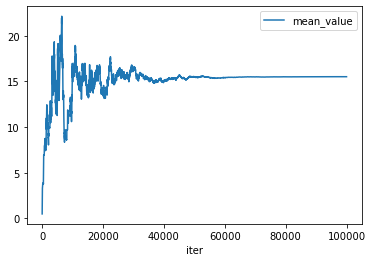

0.9999 0.05


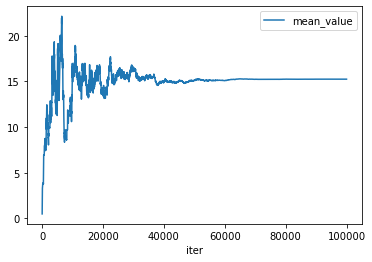

0.9999 0.1


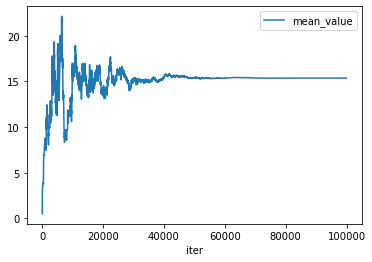

0.9999 0.3


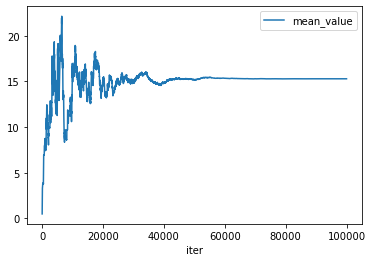

0.9999 0.5


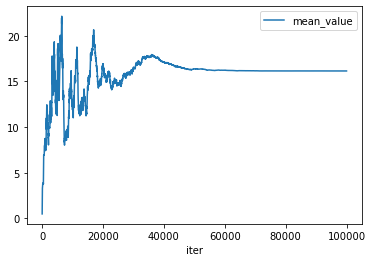

0.99999 0.01


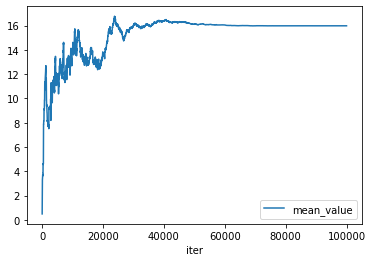

0.99999 0.05


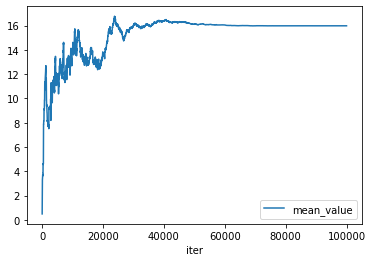

0.99999 0.1


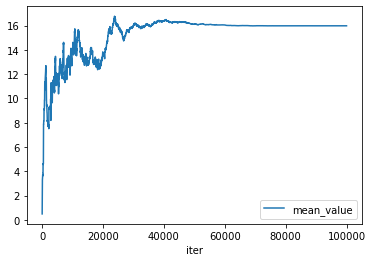

0.99999 0.3


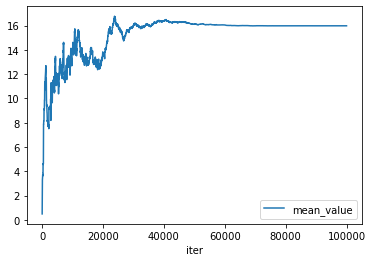

0.99999 0.5


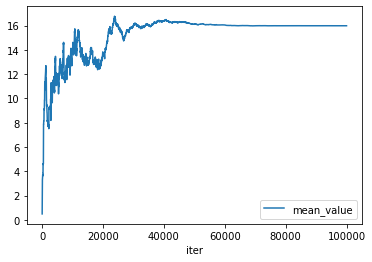

0.999999 0.01


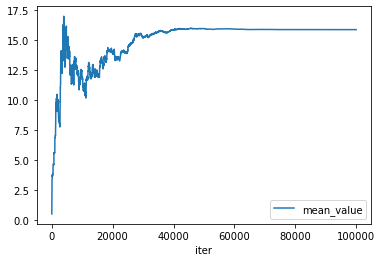

0.999999 0.05


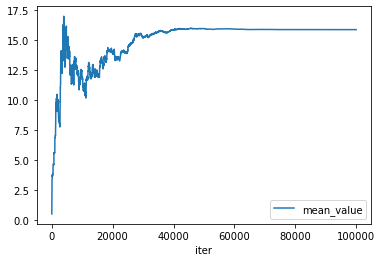

0.999999 0.1


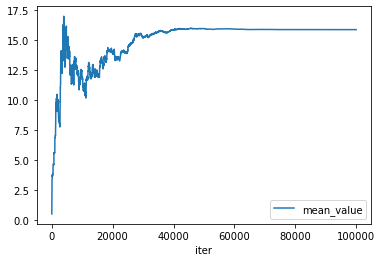

0.999999 0.3


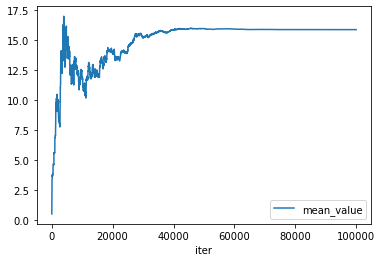

0.999999 0.5


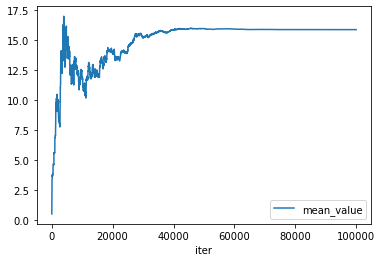

In [357]:
for e in sorted(df['epsilon_decay'].unique()):
    for e_min in sorted(df['epsilon_min'].unique()):
        print(e, e_min)
        results[prob][size][method][param].query(
            'epsilon_decay==@e and epsilon_min==@e_min and run==0'
        ).plot('iter', 'mean_value')
        plt.show()

In [192]:
# Q Learning - gamma tuning
method = 'q_learning'
size = 'large'
param = 'gamma'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
n_iter = int(1e6)
gammas = [.5, .9, .99, .999, .9999, .99999]
runs = range(5)
a_0 = 1
a = .999999
e_0 = 1
e = .999999
iter_callback = None
df = []
for g in gammas:
    policies[prob][size][method][param].setdefault(g, {})
    for i in runs:
        print(f'Gamma: {g} \tRun: {i}')
        np.random.seed(42*i)
        QL = mdp.QLearning(
            P[size],
            R[size],
            gamma=g,
            alpha=a_0,
            alpha_decay=a,
            epsilon=e_0,
            epsilon_decay=e,
            iter_callback=iter_callback,
            n_iter=n_iter
        )
        scores = QL.run()
        for r in scores:
            df.append((
                prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, r['Iteration'], r['Time'], r['Mean V'],
                r['Error']
            ))
        policies[prob][size][method][param][g][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'iter', 'time',
    'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Gamma: 0.5 	Run: 0
Gamma: 0.5 	Run: 1
Gamma: 0.5 	Run: 2
Gamma: 0.5 	Run: 3
Gamma: 0.5 	Run: 4
Gamma: 0.9 	Run: 0
Gamma: 0.9 	Run: 1
Gamma: 0.9 	Run: 2
Gamma: 0.9 	Run: 3
Gamma: 0.9 	Run: 4
Gamma: 0.99 	Run: 0
Gamma: 0.99 	Run: 1
Gamma: 0.99 	Run: 2
Gamma: 0.99 	Run: 3
Gamma: 0.99 	Run: 4
Gamma: 0.999 	Run: 0
Gamma: 0.999 	Run: 1
Gamma: 0.999 	Run: 2
Gamma: 0.999 	Run: 3
Gamma: 0.999 	Run: 4
Gamma: 0.9999 	Run: 0
Gamma: 0.9999 	Run: 1
Gamma: 0.9999 	Run: 2
Gamma: 0.9999 	Run: 3
Gamma: 0.9999 	Run: 4
Gamma: 0.99999 	Run: 0
Gamma: 0.99999 	Run: 1
Gamma: 0.99999 	Run: 2
Gamma: 0.99999 	Run: 3
Gamma: 0.99999 	Run: 4


In [193]:
results[prob][size]['policy_iteration'].groupby('gamma')['mean_value'].max()

gamma
0.50000        1.783268
0.90000        9.258969
0.99000       82.055125
0.99900      823.334542
0.99990     8235.422784
0.99999    82356.231091
Name: mean_value, dtype: float64

In [194]:
policies[prob][size]['policy_iteration'][.99][-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [204]:
policies[prob][size]['q_learning']['gamma'][.999][4][-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

0.5


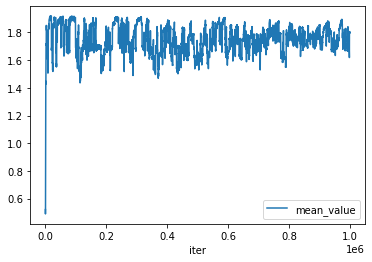

0.9


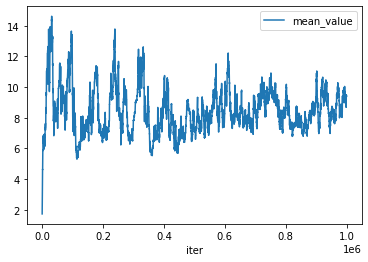

0.99


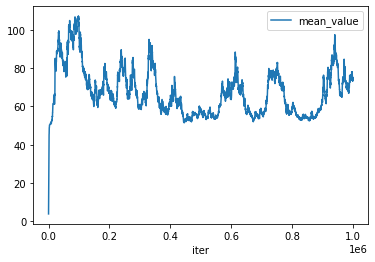

0.999


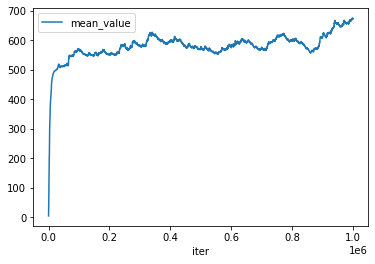

0.9999


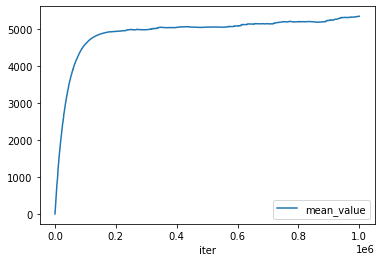

0.99999


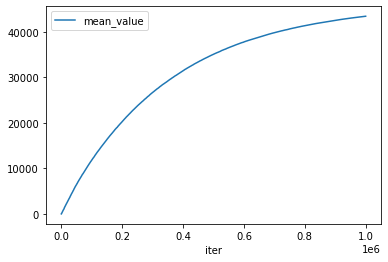

In [196]:
for g in sorted(gammas):
    print(g)
    results[prob][size][method][param].query(
        'gamma==@g and run==0'
    ).plot('iter', 'mean_value')
    plt.show()

In [205]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
ep_len = 500
for g in gammas:
    print(f'Gamma: {g}')
    for i in runs:
        r = simulate_forest_policy(P[size], R[size], policies[prob][size][method][param][g][i][-1], n, ep_len, 42*i)
        df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [225]:
policies[prob][size][method]['gamma'][.99][4][-1]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [224]:
policies[prob][size][method]['gamma'][.999][4][-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [411]:
policies[prob]['large']['policy_iteration'][.9][-1]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [206]:
df.groupby('gamma')['avg_reward'].describe()

,count,mean,std,min,25%,50%,75%,max
gamma,,,,,,,,
0.50000,5.0,236.5784,0.062612,236.510,236.515,236.595,236.630,236.642
0.90000,5.0,236.5784,0.062612,236.510,236.515,236.595,236.630,236.642
0.99000,5.0,364.5750,71.728370,236.515,390.012,395.544,398.504,402.300
0.99900,5.0,396.0920,4.625791,390.012,394.100,395.544,398.504,402.300
0.99990,5.0,300.4104,87.511291,236.515,236.595,236.630,390.012,402.300
0.99999,5.0,236.5784,0.062612,236.510,236.515,236.595,236.630,236.642


In [406]:
policies[prob]['large']['policy_iteration'][.5][-1]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [408]:
policies[prob]['large']['q_learning']['gamma'][.9999][3][-1]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [231]:
# Q - alpha tuning
method = 'q_learning'
size = 'large'
param = 'alpha'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .999
runs = range(5)
a_0 = 1
alpha_mins = [.01, .001, .0001, .00001]
alpha_decays = [.999, .9999, .99999, .999999]
e_0 = 1
e = .999999
iter_callback = None
df = []
for a in alpha_decays:
    policies[prob][size][method][param].setdefault(a, {})
    for a_min in alpha_mins:
        policies[prob][size][method][param][a].setdefault(a_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a)))
        n_iter = int(4e6)
        for i in runs:
            print(f'Alpha Decay: {a} \tAlpha Min: {a_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][a][a_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'alpha_min', 'iter',
    'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 4
Alpha Decay: 0.9999 	Alpha Min: 0.01 	Run: 0
Alpha Decay: 0.9999 	Alpha Min: 0.01 	Run: 1
Alpha Deca

0.999 1e-05


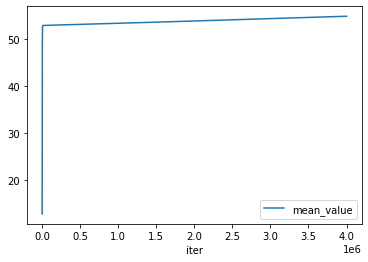

0.999 0.0001


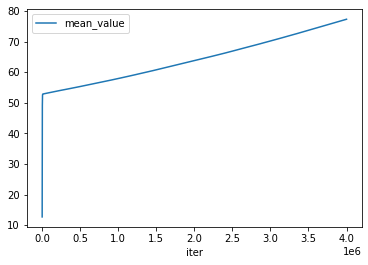

0.999 0.001


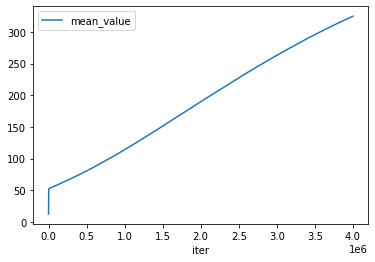

0.999 0.01


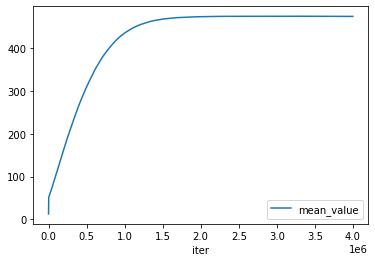

0.9999 1e-05


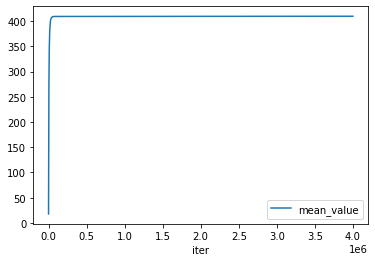

0.9999 0.0001


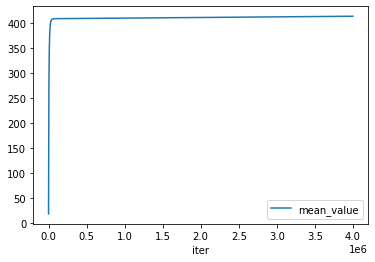

0.9999 0.001


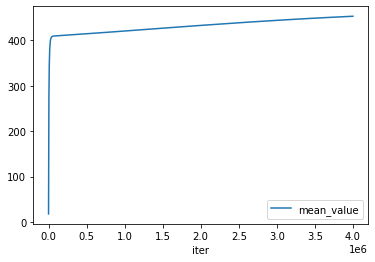

0.9999 0.01


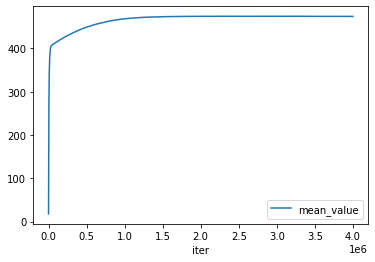

0.99999 1e-05


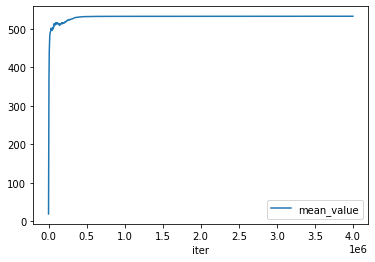

0.99999 0.0001


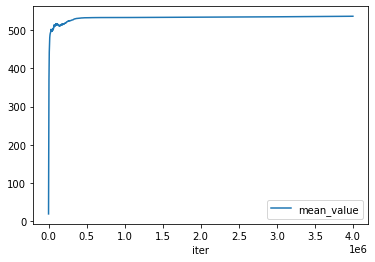

0.99999 0.001


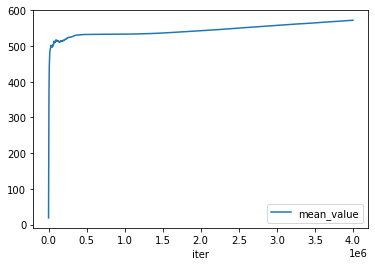

0.99999 0.01


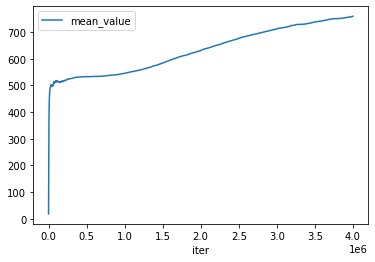

0.999999 1e-05


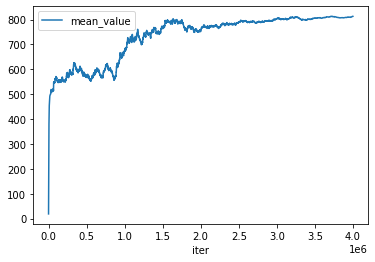

0.999999 0.0001


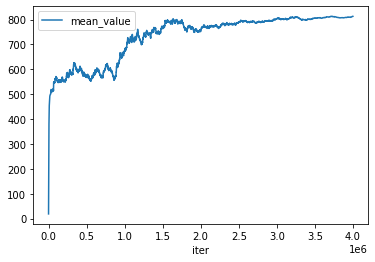

0.999999 0.001


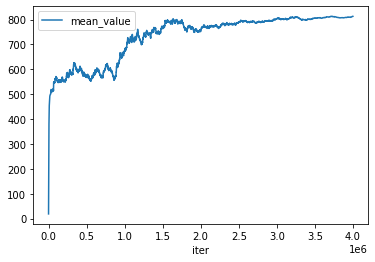

0.999999 0.01


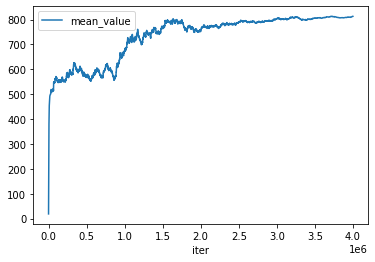

In [232]:
for a in sorted(df['alpha_decay'].unique()):
    for a_min in sorted(df['alpha_min'].unique()):
        print(a, a_min)
        results[prob][size][method][param].query(
            'alpha_decay==@a and alpha_min==@a_min and run==0'
        ).plot('iter', 'mean_value')
        plt.show()

In [248]:
policies[prob][size][method][param][.999999][.01][0][-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [290]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
ep_len = 500
for a in alpha_decays:
    for a_min in alpha_mins:
        print(f'Alpha Decay: {a} \tAlpha Min: {a_min}')
        for i in runs:
            r = simulate_forest_policy(
                P[size], R[size], policies[prob][size][method][param][a][a_min][i][-1], n, ep_len, 42*i
            )
            df.append((prob, size, method, a, a_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'alpha_decay', 'alpha_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.01
Alpha Decay: 0.999 	Alpha Min: 0.001
Alpha Decay: 0.999 	Alpha Min: 0.0001
Alpha Decay: 0.999 	Alpha Min: 1e-05
Alpha Decay: 0.9999 	Alpha Min: 0.01
Alpha Decay: 0.9999 	Alpha Min: 0.001
Alpha Decay: 0.9999 	Alpha Min: 0.0001
Alpha Decay: 0.9999 	Alpha Min: 1e-05
Alpha Decay: 0.99999 	Alpha Min: 0.01
Alpha Decay: 0.99999 	Alpha Min: 0.001
Alpha Decay: 0.99999 	Alpha Min: 0.0001
Alpha Decay: 0.99999 	Alpha Min: 1e-05
Alpha Decay: 0.999999 	Alpha Min: 0.01
Alpha Decay: 0.999999 	Alpha Min: 0.001
Alpha Decay: 0.999999 	Alpha Min: 0.0001
Alpha Decay: 0.999999 	Alpha Min: 1e-05


In [291]:
df.groupby(['alpha_decay', 'alpha_min'])['avg_reward'].describe()

count      mean       std      min      25%      50%  \
alpha_decay alpha_min                                                         
0.999000    0.00001      5.0  236.5784  0.062612  236.510  236.515  236.595   
            0.00010      5.0  236.5784  0.062612  236.510  236.515  236.595   
            0.00100      5.0  236.5784  0.062612  236.510  236.515  236.595   
            0.01000      5.0  236.5784  0.062612  236.510  236.515  236.595   
0.999900    0.00001      5.0  236.5784  0.062612  236.510  236.515  236.595   
            0.00010      5.0  236.5784  0.062612  236.510  236.515  236.595   
            0.00100      5.0  236.5784  0.062612  236.510  236.515  236.595   
            0.01000      5.0  236.5784  0.062612  236.510  236.515  236.595   
0.999990    0.00001      5.0  396.0920  4.625791  390.012  394.100  395.544   
            0.00010      5.0  396.0920  4.625791  390.012  394.100  395.544   
            0.00100      5.0  396.0920  4.625791  390.012  394.100  395.544   
            0.01000      5.0  396.0920  4.625791  390.012  394.100  395.544   
0.999999    0.00001      5.0  396.0920  4.625791  390.012  394.100  395.544   
            0.00010      5.0  396.0920  4.625791  390.012  394.100  395.544   
            0.00100      5.0  396.0920  4.625791  390.012  394.100  395.544   
            0.01000      5.0  396.0920  4.625791  390.012  394.100  395.544   

                           75%      max  
alpha_decay alpha_min                    
0.999000    0.00001    236.630  236.642  
            0.00010    236.630  236.642  
            0.00100    236.630  236.642  
            0.01000    236.630  236.642  
0.999900    0.00001    236.630  236.642  
            0.00010    236.630  236.642  
            0.00100    236.630  236.642  
            0.01000    236.630  236.642  
0.999990    0.00001    398.504  402.300  
            0.00010    398.504  402.300  
            0.00100    398.504  402.300  
            0.01000    398.504  402.300  
0.999999    0.00001    398.504  402.300  
            0.00010    398.504  402.300  
            0.00100    398.504  402.300  
            0.01000    398.504  402.300

In [252]:
# Q - epsilon tuning
method = 'q_learning'
size = 'large'
param = 'epsilon'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .999
runs = range(5)
a_0 = 1
a_min = 1e-5
a = .999999
e_0 = 1
epsilon_decays = [.99, .999, .9999, .99999, .999999]
epsilon_mins = [.5, .3, .1, .05, .01]
iter_callback = None
df = []
for e in epsilon_decays:
    policies[prob][size][method][param].setdefault(e, {})
    for e_min in epsilon_mins:
        policies[prob][size][method][param][e].setdefault(e_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a), 2*np.log(e_min)/np.log(e)))
        n_iter = int(4e6)
        for i in runs:
            print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                epsilon_min=e_min,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, e_min, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][e][e_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'epsilon_min', 'alpha', 'alpha_decay',
    'alpha_min', 'iter', 'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.01 	Run: 0
Epsilon Decay: 0.99 	Epsilon

In [295]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
ep_len = 500
for e in epsilon_decays:
    for e_min in epsilon_mins:
        print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min}')
        for i in runs:
            r = simulate_forest_policy(
                P[size], R[size], policies[prob][size][method][param][e][e_min][i][-1], n, ep_len, 42*i
            )
            df.append((prob, size, method, e, e_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'epsilon_decay', 'epsilon_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5
Epsilon Decay: 0.99 	Epsilon Min: 0.3
Epsilon Decay: 0.99 	Epsilon Min: 0.1
Epsilon Decay: 0.99 	Epsilon Min: 0.05
Epsilon Decay: 0.99 	Epsilon Min: 0.01
Epsilon Decay: 0.999 	Epsilon Min: 0.5
Epsilon Decay: 0.999 	Epsilon Min: 0.3
Epsilon Decay: 0.999 	Epsilon Min: 0.1
Epsilon Decay: 0.999 	Epsilon Min: 0.05
Epsilon Decay: 0.999 	Epsilon Min: 0.01
Epsilon Decay: 0.9999 	Epsilon Min: 0.5
Epsilon Decay: 0.9999 	Epsilon Min: 0.3
Epsilon Decay: 0.9999 	Epsilon Min: 0.1
Epsilon Decay: 0.9999 	Epsilon Min: 0.05
Epsilon Decay: 0.9999 	Epsilon Min: 0.01
Epsilon Decay: 0.99999 	Epsilon Min: 0.5
Epsilon Decay: 0.99999 	Epsilon Min: 0.3
Epsilon Decay: 0.99999 	Epsilon Min: 0.1
Epsilon Decay: 0.99999 	Epsilon Min: 0.05
Epsilon Decay: 0.99999 	Epsilon Min: 0.01
Epsilon Decay: 0.999999 	Epsilon Min: 0.5
Epsilon Decay: 0.999999 	Epsilon Min: 0.3
Epsilon Decay: 0.999999 	Epsilon Min: 0.1
Epsilon Decay: 0.999999 	Epsilon Min: 0.05
Epsilon Decay: 0.999999 	Epsilon 

In [296]:
df.groupby(['epsilon_decay', 'epsilon_min'])['avg_reward'].describe()

count      mean        std      min      25%  \
epsilon_decay epsilon_min                                                 
0.990000      0.01           5.0  331.1776  86.356510  236.630  236.642   
              0.05           5.0  396.0920   4.625791  390.012  394.100   
              0.10           5.0  396.0920   4.625791  390.012  394.100   
              0.30           5.0  396.0920   4.625791  390.012  394.100   
              0.50           5.0  396.0920   4.625791  390.012  394.100   
0.999000      0.01           5.0  300.4104  87.511291  236.515  236.595   
              0.05           5.0  396.0920   4.625791  390.012  394.100   
              0.10           5.0  396.0920   4.625791  390.012  394.100   
              0.30           5.0  396.0920   4.625791  390.012  394.100   
              0.50           5.0  396.0920   4.625791  390.012  394.100   
0.999900      0.01           5.0  365.3916  72.115302  236.510  394.100   
              0.05           5.0  396.0920   4.625791  390.012  394.100   
              0.10           5.0  396.0920   4.625791  390.012  394.100   
              0.30           5.0  396.0920   4.625791  390.012  394.100   
              0.50           5.0  396.0920   4.625791  390.012  394.100   
0.999990      0.01           5.0  396.0920   4.625791  390.012  394.100   
              0.05           5.0  396.0920   4.625791  390.012  394.100   
              0.10           5.0  396.0920   4.625791  390.012  394.100   
              0.30           5.0  396.0920   4.625791  390.012  394.100   
              0.50           5.0  396.0920   4.625791  390.012  394.100   
0.999999      0.01           5.0  396.0920   4.625791  390.012  394.100   
              0.05           5.0  396.0920   4.625791  390.012  394.100   
              0.10           5.0  396.0920   4.625791  390.012  394.100   
              0.30           5.0  396.0920   4.625791  390.012  394.100   
              0.50           5.0  396.0920   4.625791  390.012  394.100   

                               50%      75%      max  
epsilon_decay epsilon_min                             
0.990000      0.01         390.012  394.100  398.504  
              0.05         395.544  398.504  402.300  
              0.10         395.544  398.504  402.300  
              0.30         395.544  398.504  402.300  
              0.50         395.544  398.504  402.300  
0.999000      0.01         236.630  390.012  402.300  
              0.05         395.544  398.504  402.300  
              0.10         395.544  398.504  402.300  
              0.30         395.544  398.504  402.300  
              0.50         395.544  398.504  402.300  
0.999900      0.01         395.544  398.504  402.300  
              0.05         395.544  398.504  402.300  
              0.10         395.544  398.504  402.300  
              0.30         395.544  398.504  402.300  
              0.50         395.544  398.504  402.300  
0.999990      0.01         395.544  398.504  402.300  
              0.05         395.544  398.504  402.300  
              0.10         395.544  398.504  402.300  
              0.30         395.544  398.504  402.300  
              0.50         395.544  398.504  402.300  
0.999999      0.01         395.544  398.504  402.300  
              0.05         395.544  398.504  402.300  
              0.10         395.544  398.504  402.300  
              0.30         395.544  398.504  402.300  
              0.50         395.544  398.504  402.300

0.99 0.01


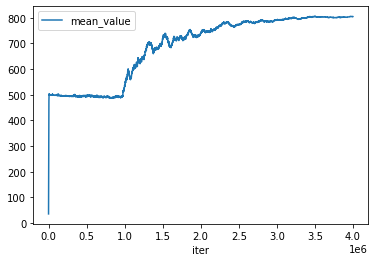

0.99 0.05


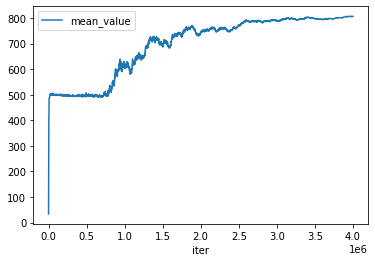

0.99 0.1


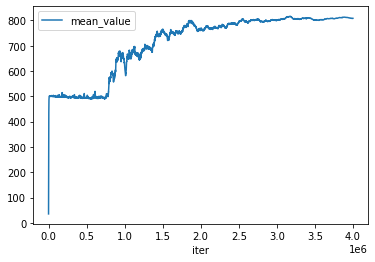

0.99 0.3


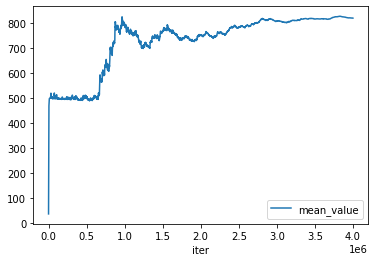

0.99 0.5


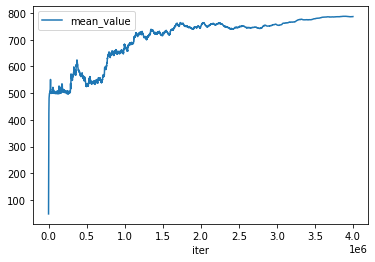

0.999 0.01


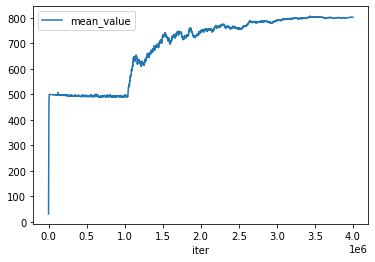

0.999 0.05


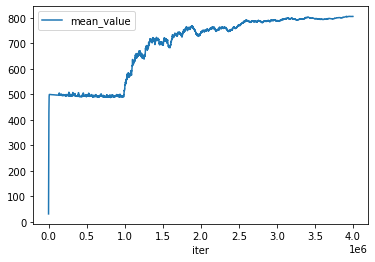

0.999 0.1


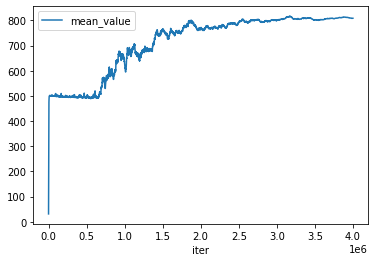

0.999 0.3


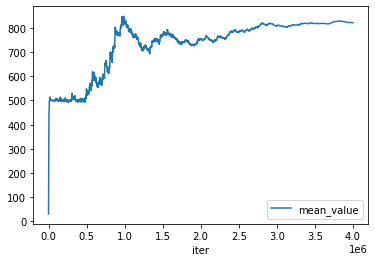

0.999 0.5


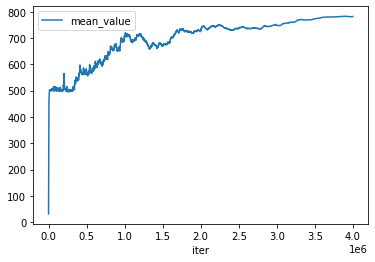

0.9999 0.01


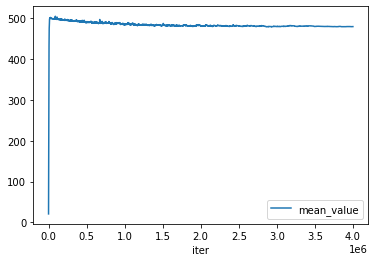

0.9999 0.05


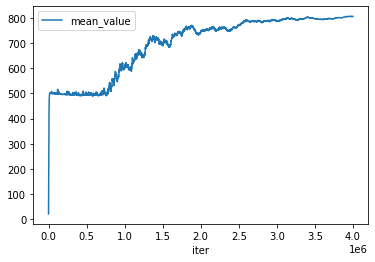

0.9999 0.1


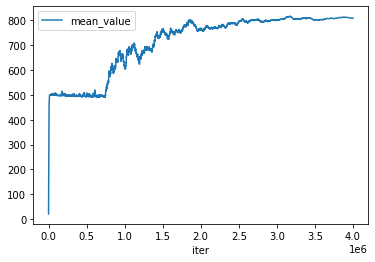

0.9999 0.3


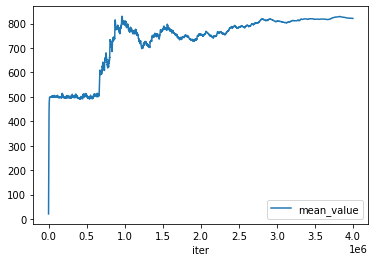

0.9999 0.5


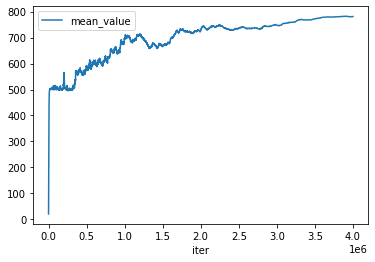

0.99999 0.01


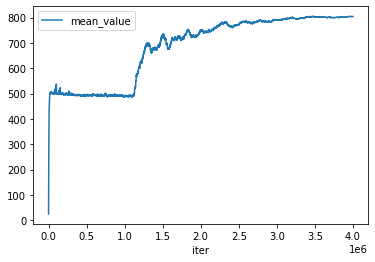

0.99999 0.05


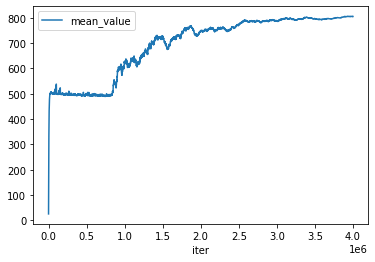

0.99999 0.1


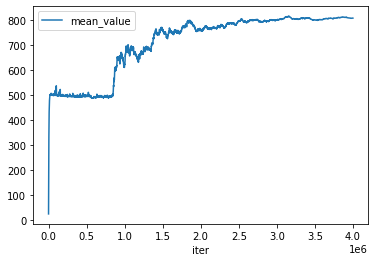

0.99999 0.3


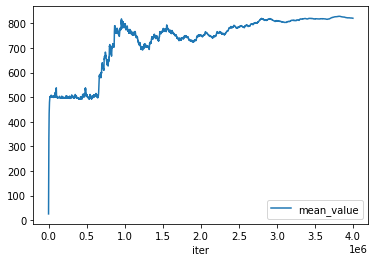

0.99999 0.5


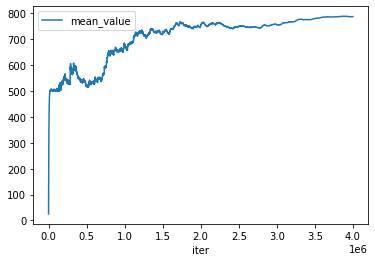

0.999999 0.01


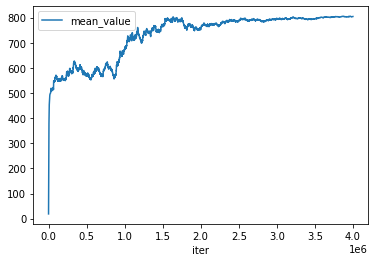

0.999999 0.05


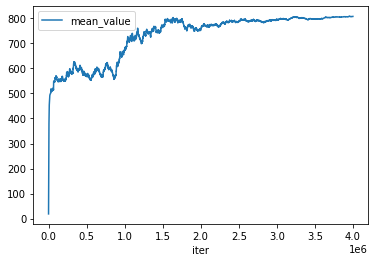

0.999999 0.1


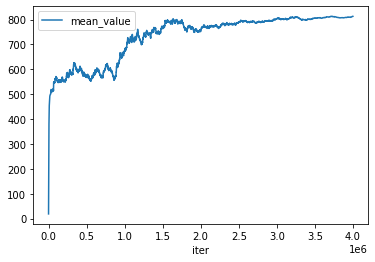

0.999999 0.3


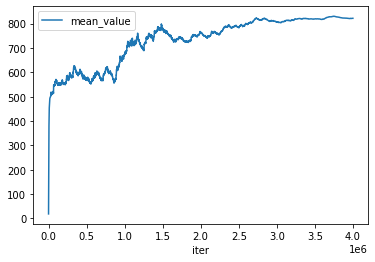

0.999999 0.5


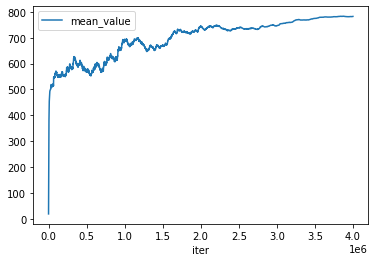

In [256]:
for e in sorted(df['epsilon_decay'].unique()):
    for e_min in sorted(df['epsilon_min'].unique()):
        print(e, e_min)
        results[prob][size][method][param].query(
            'epsilon_decay==@e and epsilon_min==@e_min and run==0'
        ).plot('iter', 'mean_value')
        plt.show()

In [297]:
save_results(results, folder='./results')
save_results(policies, folder='./policies')
save_results(simulations, folder='./simulations')